In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import humanfriendly as HF
import os 
import sys
import string
import re
import random
np.random.seed(0)
import logging
format = "%(asctime)s: %(message)s"
handlers = [logging.StreamHandler(sys.stdout)]
logging.basicConfig(format=format, level=logging.INFO,datefmt="%H:%M:%S",stream=sys.stdout)
OUTPUT_PATH      = os.environ.get("OUTPUT_PATH","/source/mx-test")
MAX_WORKERS      = int(os.environ.get("MAX_WORKERS",5))
TRACE_PATH       = os.environ.get("TRACE_PATH",f"/traces")
n_operations     = int(os.environ.get("N_OPERATIONS",10000))
avg_interarrival = float(os.environ.get("AVG_INTERARRIVAL_TIME",10.0))  
num_buckets      = int(os.environ.get("NUM_BUCKETS",1))  # For simplicity, one bucket (can be more)
num_keys         = int(os.environ.get("NUM_KEYS",10))  # Number of unique keys

14:00:29: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
14:00:29: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


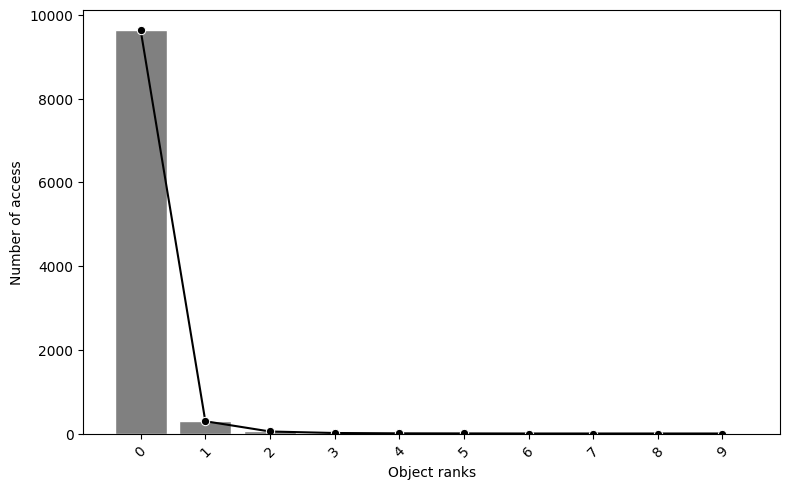

In [20]:
# p.random.seed(0)

def generate_interarrival_times(n, avg_interarrival, distribution="exponential",**kwargs):
    """Generate interarrival times based on a specified distribution."""
    if distribution == "exponential":
        return np.random.exponential(scale=avg_interarrival, size=n)
    elif distribution == "uniform":
        return np.random.uniform(low=0, high=2 * avg_interarrival, size=n)
    elif distribution == "geometric":
        return np.random.geometric(p=1.0 / avg_interarrival, size=n)
    elif distribution == "poisson":
        return np.random.poisson(lam=avg_interarrival, size=n)
    else:
        raise ValueError("Unsupported interarrival time distribution")

def generate_object_rankings(n, num_objects, distribution="zipf",**kwargs):
    """Generate object rankings based on a specified probability distribution."""
    if distribution == "zipf":
        return np.random.zipf(a=kwargs.get("alpha",1.2), size=n) % num_objects
    elif distribution == "uniform":
        # return np.random.zipf(a=0,size=n) % num_objects
        return np.random.randint(low=0, high=num_objects, size=n)
    elif distribution == "geometric":
        return np.random.geometric(p=kwargs.get("p",0.5), size=n) % num_objects
    elif distribution == "exponential":
        return np.random.exponential(scale=kwargs.get("scale",1.0), size=n).astype(int) % num_objects
    else:
        raise ValueError("Unsupported ranking distribution")

def generate_consumer_trace(n, avg_interarrival, num_buckets, num_keys, ranking_dist="zipf", interarrival_dist="exponential", save=False,**kwargs):
    """Generate a consumer trace (reads) ensuring each unique object is accessed at least once.
    
    Each unique object is defined as a combination of bucket and key.
    The trace will include guaranteed accesses for all unique objects, and the remaining accesses
    are generated based on the selected probability distribution.
    """
    total_unique = num_buckets * num_keys
    
    # Generate guaranteed keys: all unique combinations.
    guaranteed_keys = [f"bucket-{b}_key-{k}" for b in range(num_buckets) for k in range(num_keys)]
    
    # If n is less than total_unique, choose n unique objects randomly.
    if n < total_unique:
        guaranteed_keys = random.sample(guaranteed_keys, n)
        remainder = 0
    else:
        remainder = n - total_unique
    
    additional_keys = []
    if remainder > 0:
        # Generate additional keys based on the ranking distribution over total_unique objects.
        additional_indices = generate_object_rankings(remainder, total_unique, distribution=ranking_dist,**kwargs)
        additional_keys = [guaranteed_keys[i] for i in additional_indices]
    
    # Combine the guaranteed keys with the additional keys
    all_keys = guaranteed_keys + additional_keys
    # Shuffle the order to simulate random accesses
    random.shuffle(all_keys)
    
    # Generate interarrival times and timestamps
    interarrival_times = generate_interarrival_times(n, avg_interarrival, interarrival_dist)
    timestamps = np.cumsum(interarrival_times)
    
    # For simplicity, randomly assign bucket_id from the object key (if desired, extract bucket from the key)
    bucket_ids = [key.split('_')[0] for key in all_keys]
    
    df = pd.DataFrame({
        "timestamp": timestamps,
        "interarrival_time": interarrival_times,
        "bucket_id": bucket_ids,
        "key": all_keys
    })
    df = process_consumer_trace(df)
    
    if save:
        df.to_csv(f"{TRACE_PATH}/mx-{n}_{num_keys}_{ranking_dist[:4]}_{interarrival_dist[:4]}.csv", index=False)
    
    return df

def process_consumer_trace(consumer_df):
    """
    Process a consumer trace:
      - For each unique combination of bucket_id and key, mark the first occurrence as 'PUT'
        and subsequent occurrences as 'GET'.
      - Modify the key column by removing the '{bucket_id}_' prefix.
    
    Parameters:
      consumer_df: DataFrame with columns [timestamp, interarrival_time, bucket_id, key]
      
    Returns:
      processed_df: DataFrame with an additional 'operation' column and updated 'key'.
    """
    # Sort the DataFrame by timestamp to ensure proper chronological order
    consumer_df = consumer_df.sort_values(by="timestamp").reset_index(drop=True)
    
    # Initialize a dictionary to keep track of seen (bucket_id, key) combinations
    seen = {}
    operations = []
    new_keys = []
    sizes  = []
    
    avg_object_size = HF.parse_size("1MB")
    std_object_size = HF.parse_size("1MB")
    for _, row in consumer_df.iterrows():
        bucket = row["bucket_id"]
        key = row["key"]
        # Remove the bucket prefix from the key if it follows the pattern "{bucket_id}_{string}"
        prefix = f"{bucket}_"
        if key.startswith(prefix):
            key_modified = key[len(prefix):]
        else:
            key_modified = key
        
        # Use (bucket, key_modified) as the unique combination
        combination = (bucket, key_modified)
        if combination not in seen:
            seen[combination] = True
            operations.append("PUT")
        else:
            operations.append("GET")
        
        new_keys.append(key_modified)
        sizes.append(0)
    
    # Add new columns to the DataFrame
    consumer_df["operation"] = operations
    consumer_df["key"] = new_keys  # Update the key column without bucket prefix
    consumer_df["size"] = np.random.normal(loc=avg_object_size, scale=std_object_size)
    
    # Reorder columns if desired
    processed_df = consumer_df[["timestamp", "interarrival_time", "operation", "bucket_id", "key","size"]]
    return processed_df

def plot_object_ranking_distribution(consumer_trace, num_keys:int=10,name:str="plot",save:bool = False):
    """Plot the object ranking distribution to verify trace generation."""
    plt.figure(figsize=(8, 5))
    
    # Count frequency of accesses per object (key)
    object_counts = consumer_trace["key"].value_counts().sort_values(ascending=False)
    
    # Limit to the top `num_keys` most accessed objects
    top_keys = object_counts.head(num_keys)
    x=range(0,num_keys)
    sns.barplot(x=x, y=top_keys.values, color="grey", edgecolor="white")
    sns.lineplot(x=x, y=top_keys.values, color="black",marker="o")
    
    plt.xlabel("Object ranks")
    plt.ylabel("Number of access")
    # plt.title(f"Object Access Distribution (from Trace)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save:
        plt.savefig(f"./plots/{name}.png")
    plt.show()
# Example Usage:


save             = bool(int(os.environ.get("SAVE","0")))
save_plot             = bool(int(os.environ.get("SAVE_PLOT","1")))
# Generate the consumer trace for different ranking distributions:
consumer_trace_zipf = generate_consumer_trace(
    n_operations, 
    avg_interarrival, 
    num_buckets, num_keys, ranking_dist="zipf",save=save,alpha=5)
consumer_trace_uniform = generate_consumer_trace(n_operations, avg_interarrival, num_buckets, num_keys, ranking_dist="uniform",save=save)
consumer_trace_geometric = generate_consumer_trace(n_operations, avg_interarrival, num_buckets, num_keys, ranking_dist="geometric",save=save)
consumer_trace_exponential = generate_consumer_trace(n_operations, avg_interarrival, num_buckets, num_keys, ranking_dist="exponential",save=save)

# Plot the object access distribution for the Zipf-based consumer trace
plot_object_ranking_distribution(consumer_trace_zipf, save=save_plot,name="access_zipf")
# plot_object_ranking_distribution(consumer_trace_uniform,save=save_plot, name="access_uniform")
# plot_object_ranking_distribution(consumer_trace_geometric)
# plot_object_ranking_distribution(consumer_trace_exponential,save=save_plot, name="access_exp")
# consumer_trace_zipf
# print("Producer and Consumer traces have been generated and saved.")


In [4]:
consumer_trace_zipf[consumer_trace_zipf["operation"]=="PUT"]

,timestamp,interarrival_time,operation,bucket_id,key,size
0,0.319707,0.319707,PUT,bucket-0,key-9,-402330.532885
2,2.031001,1.474671,PUT,bucket-0,key-3,-402330.532885
3,2.430011,0.399010,PUT,bucket-0,key-1,-402330.532885
4,2.549373,0.119361,PUT,bucket-0,key-0,-402330.532885
5,3.327849,0.778477,PUT,bucket-0,key-2,-402330.532885
6,3.461939,0.134090,PUT,bucket-0,key-4,-402330.532885
9,6.500667,0.460705,PUT,bucket-0,key-8,-402330.532885
10,7.501723,1.001056,PUT,bucket-0,key-5,-402330.532885
12,8.372738,0.148181,PUT,bucket-0,key-6,-402330.532885
25,21.606117,0.603862,PUT,bucket-0,key-7,-402330.532885


In [204]:
HF.format_size(consumer_trace_exponential[consumer_trace_exponential["operation"] =="PUT"]["size"].sum())

'12.33 MB'

   timestamp  interarrival_time bucket_id    key
0        1.0                1.0  bucket-0  key-8
1        1.0                1.0  bucket-0  key-9
2        1.0                1.0  bucket-0  key-4
3        2.1                1.1  bucket-0  key-8
4        2.1                1.1  bucket-0  key-9


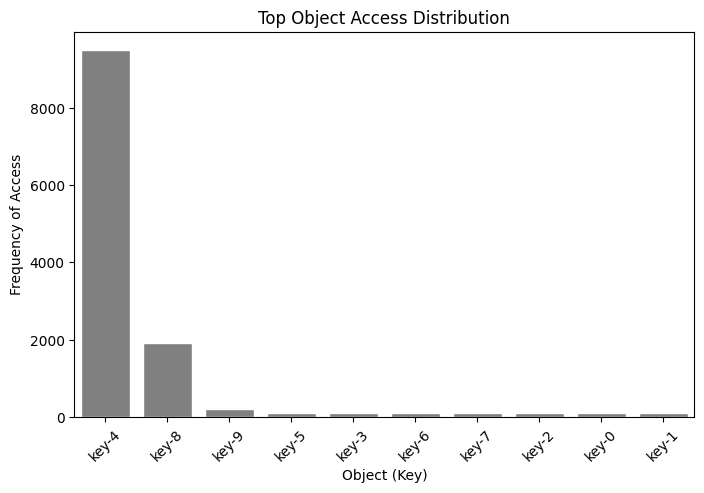

In [22]:
import numpy as np
import pandas as pd
import random

def generate_dynamic_consumer_trace(n_objects, pop_frac=0.2, min_events=5, max_events=20,
                                    base_rate_pop=1.0, base_rate_nonpop=3.0, factor=0.1):
    """
    Generate a consumer trace with columns: timestamp, interarrival_time, bucket_id, key.
    Each unique object (key) is accessed multiple times with a decaying access frequency over time.
    A fraction of objects (pop_frac) are considered super popular and receive more accesses,
    while the remaining objects are less frequently accessed.
    
    Parameters:
      n_objects (int): Number of unique objects (keys) to generate.
      pop_frac (float): Fraction of objects considered super popular.
      min_events (int): Minimum number of accesses per object.
      max_events (int): Maximum number of accesses per object for popular objects.
      base_rate_pop (float): Base interarrival time for super popular objects.
      base_rate_nonpop (float): Base interarrival time for non-popular objects.
      factor (float): Incremental factor to increase interarrival time for each subsequent access.
      
    Returns:
      consumer_trace (DataFrame): DataFrame with columns [timestamp, interarrival_time, bucket_id, key].
    """
    all_events = []
    
    for obj_id in range(n_objects):
        # Determine if the object is super popular
        is_popular = random.random() < pop_frac
        
        # Set the base interarrival time accordingly
        base_rate = base_rate_pop if is_popular else base_rate_nonpop
        
        # Determine the number of access events for this object
        if is_popular:
            n_events = random.randint(min_events, max_events)
        else:
            n_events = random.randint(min_events, min_events + 5)
        
        # Generate interarrival times that increase gradually (simulating decay in access frequency)
        interarrival_times = [base_rate * (1 + i * factor) for i in range(n_events)]
        timestamps = np.cumsum(interarrival_times)
        
        # Define bucket_id and key (assuming a single bucket for simplicity)
        bucket_id = "bucket-0"
        key = f"key-{obj_id}"
        
        # Append each event for this object to the list
        for t, it in zip(timestamps, interarrival_times):
            all_events.append({
                "timestamp": t,
                "interarrival_time": it,
                "bucket_id": bucket_id,
                "key": key
            })
    
    # Create DataFrame, sort by timestamp and reset index
    consumer_trace = pd.DataFrame(all_events)
    consumer_trace.sort_values("timestamp", inplace=True)
    consumer_trace.reset_index(drop=True, inplace=True)
    
    return consumer_trace

# Example usage:
n_objects = 10  # Number of unique objects
avg_interarrival = 2.0  # Not directly used here, as we control interarrival via base rates
consumer_trace = generate_dynamic_consumer_trace(n_objects, pop_frac=0.3, min_events=100, max_events=10000,
                                                   base_rate_pop=1.0, base_rate_nonpop=3.0, factor=0.1)

# Save to CSV
# consumer_trace.to_csv("dynamic_consumer_trace.csv", index=False)
print(consumer_trace.head())



def plot_object_ranking_distribution(consumer_trace, top_n=10):
    """Plot the frequency of accesses per object (key) from the consumer trace."""
    plt.figure(figsize=(8, 5))
    object_counts = consumer_trace["key"].value_counts().sort_values(ascending=False)
    top_objects = object_counts.head(top_n)
    
    sns.barplot(x=top_objects.index, y=top_objects.values, color="grey", edgecolor="white")
    plt.xlabel("Object (Key)")
    plt.ylabel("Frequency of Access")
    plt.title("Top Object Access Distribution")
    plt.xticks(rotation=45)
    plt.show()

# Plot the top 10 objects' access distribution
plot_object_ranking_distribution(consumer_trace, top_n=10)


In [28]:
def generate_dynamic_consumer_trace(n_objects, pop_frac=0.2, 
                                    min_events_pop=10, max_events_pop=20,
                                    min_events_nonpop=3, max_events_nonpop=7,
                                    base_rate_pop=1.0, base_rate_nonpop=3.0, factor=0.1):
    """
    Generate a consumer trace with columns: timestamp, interarrival_time, bucket_id, key.
    Each unique object (key) is accessed multiple times with a decaying access frequency over time.
    A fraction (pop_frac) of objects are considered super popular and receive many accesses,
    while the remaining objects are less frequently accessed.
    
    Parameters:
      n_objects (int): Number of unique objects (keys) to generate.
      pop_frac (float): Fraction of objects considered super popular.
      min_events_pop (int): Minimum number of accesses for popular objects.
      max_events_pop (int): Maximum number of accesses for popular objects.
      min_events_nonpop (int): Minimum number of accesses for non-popular objects.
      max_events_nonpop (int): Maximum number of accesses for non-popular objects.
      base_rate_pop (float): Base interarrival time for popular objects.
      base_rate_nonpop (float): Base interarrival time for non-popular objects.
      factor (float): Incremental factor to increase interarrival time for each subsequent access.
      
    Returns:
      consumer_trace (DataFrame): DataFrame with columns [timestamp, interarrival_time, bucket_id, key].
    """
    all_events = []
    
    for obj_id in range(n_objects):
        # Determine if the object is super popular
        is_popular = random.random() < pop_frac
        # Set base interarrival time accordingly
        base_rate = base_rate_pop if is_popular else base_rate_nonpop
        
        # Determine the number of access events for this object
        if is_popular:
            n_events = random.randint(min_events_pop, max_events_pop)
        else:
            n_events = random.randint(min_events_nonpop, max_events_nonpop)
        
        # Generate interarrival times that increase gradually (simulating decay in access frequency)
        interarrival_times = [base_rate * (1 + i * factor) for i in range(n_events)]
        timestamps = np.cumsum(interarrival_times)
        
        # For simplicity, assume a single bucket for all objects.
        bucket_id = "bucket-0"
        key = f"key-{obj_id}"  # Unique key per object
        
        for t, it in zip(timestamps, interarrival_times):
            all_events.append({
                "timestamp": t,
                "interarrival_time": it,
                "bucket_id": bucket_id,
                "key": key
            })
    
    # Create DataFrame, sort by timestamp and reset index
    consumer_trace = pd.DataFrame(all_events)
    consumer_trace.sort_values("timestamp", inplace=True)
    consumer_trace.reset_index(drop=True, inplace=True)
    
    return consumer_trace

# Example usage:
n_objects = 5   # Number of unique objects
consumer_trace = generate_dynamic_consumer_trace(n_objects, pop_frac=.5, 
                                                 min_events_pop=100, max_events_pop=1000,
                                                 min_events_nonpop=3, max_events_nonpop=7,
                                                 base_rate_pop=1.0, base_rate_nonpop=3.0, factor=0.1)

# plot_object_ranking_distribution(consumer_trace, top_n=10)

# Save the trace to CSV (optional)
# consumer_trace.to_csv("dynamic_consumer_trace.csv", index=False)
# print(consumer_trace.head(), consumer_trace.size)

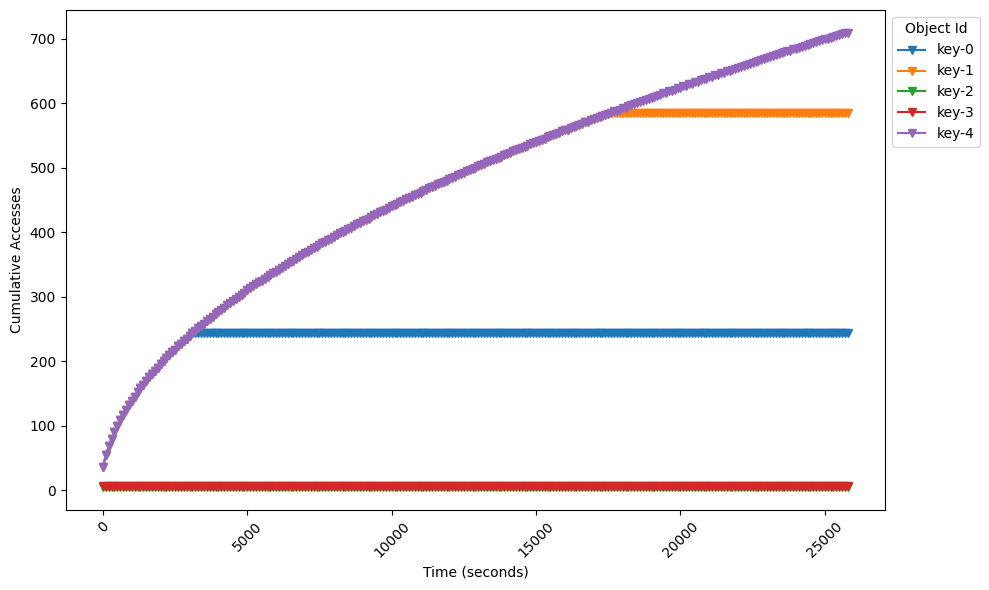

In [29]:
def plot_cumsum_access(consumer_trace, interval=10, specific_key=None):
    """
    Plot the cumulative sum of accesses every 'interval' seconds in the consumer trace.
    
    Parameters:
      consumer_trace: DataFrame with columns [timestamp, interarrival_time, bucket_id, key]
      interval: time interval in seconds for grouping events.
      specific_key: if provided, only plot the cumulative sum for this key; otherwise, plot for all keys.
    """
    # Create a new column for time bins
    consumer_trace = consumer_trace.copy()
    consumer_trace["time_bin"] = (consumer_trace["timestamp"] // interval) * interval
    
    if specific_key:
        # Filter trace for the specific key
        df_key = consumer_trace[consumer_trace["key"] == specific_key]
        # Group by time_bin and count events, then compute cumulative sum
        cumsum_data = df_key.groupby("time_bin").size().cumsum()
        
        plt.figure(figsize=(8, 5))
        plt.plot(cumsum_data.index, cumsum_data.values, marker="o", label=f"Key: {specific_key}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Cumulative Accesses")
        plt.title(f"Cumulative Sum of Accesses for Key {specific_key} (Interval: {interval} sec)")
        plt.legend()
        plt.show()
    else:
        # Group by time_bin and key, count events, then compute cumulative sum for each key
        grouped = consumer_trace.groupby(["time_bin", "key"]).size().unstack(fill_value=0)
        cumsum_grouped = grouped.cumsum()
        
        plt.figure(figsize=(10, 6))
        for key in cumsum_grouped.columns:
            plt.plot(cumsum_grouped.index, cumsum_grouped[key], marker="v", label=f"{key}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Cumulative Accesses")
        # plt.title(f"Cumulative Sum of Accesses for All Keys (Interval: {interval} sec)")
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1),title="Object Id")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage:
# Assuming consumer_trace is a DataFrame with columns: timestamp, interarrival_time, bucket_id, key.
# For demonstration, let's create a sample consumer trace:
# data = {
#     "timestamp": np.sort(np.random.uniform(0, 300, 1000)),  # 1000 events over 300 seconds
#     "interarrival_time": np.random.exponential(scale=2.0, size=1000),
#     "bucket_id": ["bucket-0"] * 1000,
#     "key": [f"key-{np.random.randint(0, 50)}" for _ in range(1000)]
# }
# consumer_trace = pd.DataFrame(data)

# Plot cumulative sum of accesses for all keys with 10-second intervals
plot_cumsum_access(consumer_trace, interval=100)

# Plot cumulative sum for a specific key, for example "key-0"
# plot_cumsum_access(consumer_trace, interval=10, specific_key="key-0")

In [63]:
np.random.seed(10)
def generate_dynamic_consumer_trace(n_objects=10, pop_frac=0.5, 
                                    min_events_pop=10, max_events_pop=20,
                                    min_events_nonpop=3, max_events_nonpop=7,
                                    base_rate_pop=1.0, base_rate_nonpop=3.0, factor=0.1):
    """
    Generate a consumer trace with columns: timestamp, interarrival_time, bucket_id, key.
    Each unique object (key) is accessed multiple times with an access frequency that decays exponentially for popular objects,
    while less popular objects are accessed uniformly (or barely).
    
    Parameters:
      n_objects (int): Number of unique objects (keys) to generate.
      pop_frac (float): Fraction of objects considered super popular.
      min_events_pop (int): Minimum number of accesses for popular objects.
      max_events_pop (int): Maximum number of accesses for popular objects.
      min_events_nonpop (int): Minimum number of accesses for non-popular objects.
      max_events_nonpop (int): Maximum number of accesses for non-popular objects.
      base_rate_pop (float): Base interarrival time for popular objects (lower, so initial accesses are frequent).
      base_rate_nonpop (float): Base interarrival time for non-popular objects.
      factor (float): Incremental factor for exponential increase in interarrival times for popular objects.
      
    Returns:
      consumer_trace (DataFrame): DataFrame with columns [timestamp, interarrival_time, bucket_id, key].
    """
    all_events = []
    
    for obj_id in range(n_objects):
        # Determine if the object is super popular
        is_popular = random.random() < pop_frac
        
        if is_popular:
            # For popular objects, use an exponential increase in interarrival times (access decay)
            n_events = random.randint(min_events_pop, max_events_pop)
            interarrival_times = [base_rate_pop * ((1 + factor) ** i) for i in range(n_events)]
        else:
            # For non-popular objects, use a constant interarrival time (uniform sparse accesses)
            n_events = random.randint(min_events_nonpop, max_events_nonpop)
            interarrival_times = [base_rate_nonpop for _ in range(n_events)]
        
        timestamps = np.cumsum(interarrival_times)
        
        # Define bucket_id and key (assuming a single bucket for simplicity)
        bucket_id = "bucket-0"
        key = f"key-{obj_id}"  # Unique key per object
        
        for t, it in zip(timestamps, interarrival_times):
            all_events.append({
                "timestamp": t,
                "interarrival_time": it,
                "bucket_id": bucket_id,
                "key": key
            })
    
    # Create DataFrame, sort by timestamp and reset index
    consumer_trace = pd.DataFrame(all_events)
    consumer_trace.sort_values("timestamp", inplace=True)
    consumer_trace.reset_index(drop=True, inplace=True)
    
    return consumer_trace

# Example usage:
n_objects = 10   # Number of unique objects
consumer_trace = generate_dynamic_consumer_trace(n_objects, pop_frac=0.2, 
                                                   min_events_pop=1, max_events_pop=1000,
                                                   min_events_nonpop=3, max_events_nonpop=7,
                                                   base_rate_pop=1.0, base_rate_nonpop=3.0, factor=0.1)

# Save to CSV
# consumer_trace.to_csv("dynamic_consumer_trace.csv", index=False)
print(consumer_trace.head())

# Plotting the access decay over time for a specific key or for all keys:

def plot_access_decay(consumer_trace, interval=10, specific_key=None,ax=None):
    """
    Plot the number of accesses per fixed time interval to observe decay in access frequency.
    
    Parameters:
      consumer_trace (DataFrame): Trace with columns [timestamp, interarrival_time, bucket_id, key].
      interval (int): Time interval in seconds for grouping events.
      specific_key (str, optional): If provided, plot only for this key; otherwise, aggregate across all keys.
    """
    df = consumer_trace.copy()
    if specific_key:
        df = df[df["key"] == specific_key]
    
    # Create time bins
    df["time_bin"] = (df["timestamp"] // interval) * interval
    # Count events per time bin
    access_counts = df.groupby("time_bin").size().reset_index(name="access_count")
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x="time_bin", y="access_count", data=access_counts, color="grey", edgecolor="black",ax=ax)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Number of Accesses")
    title = "Access Frequency Over Time"
    if specific_key:
        title += f" for {specific_key}"
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.show()

# Plot for a specific key (e.g., "key-0")
ncols = 5
nrows = 2
# _,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(20,5))
z = 0
# for i in range(ncols):
#     for j in range(nrows):
#         z+=1
#         plot_access_decay(consumer_trace, interval=2, specific_key=f"key-{z}",ax=axs[j][i])
# To plot for all keys combined, call without specific_key:
# plot_access_decay(consumer_trace, interval=10)

   timestamp  interarrival_time bucket_id    key
0        1.0                1.0  bucket-0  key-3
1        1.0                1.0  bucket-0  key-1
2        1.0                1.0  bucket-0  key-9
3        2.1                1.1  bucket-0  key-3
4        2.1                1.1  bucket-0  key-1


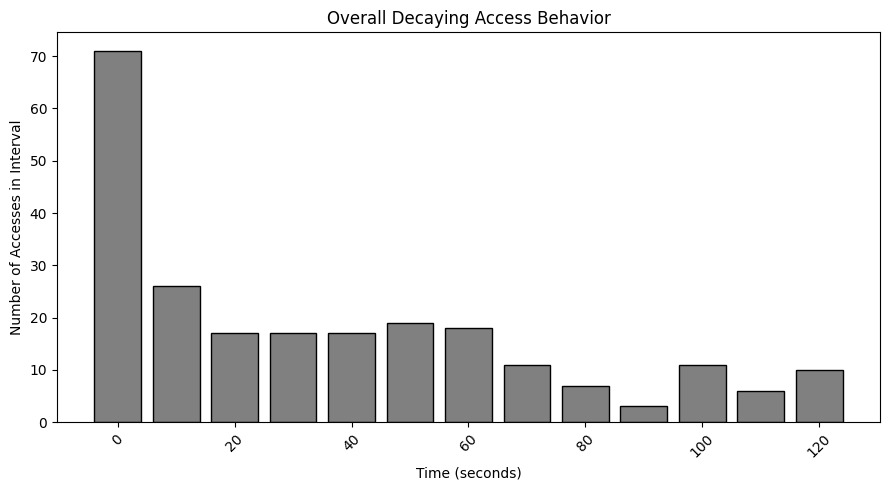

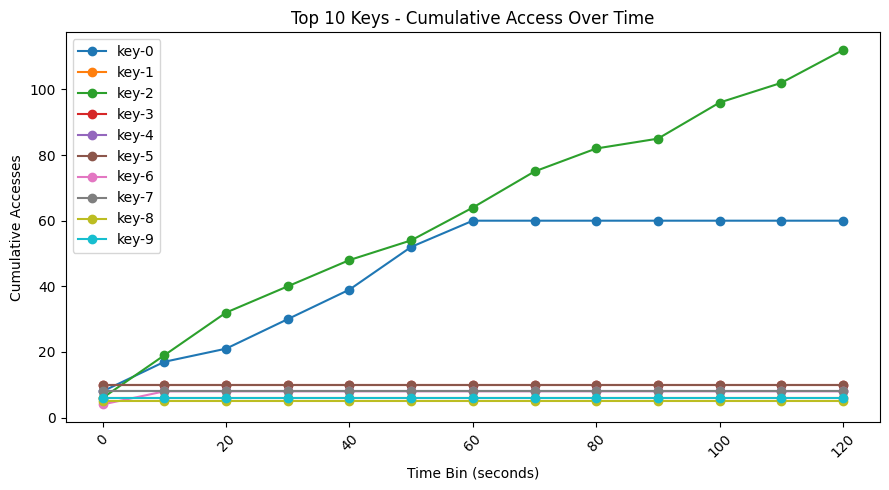

In [ ]:
def generate_decay_trace(n_objects=100, pop_frac=0.2,
                         min_events_pop=20, max_events_pop=40,
                         min_events_nonpop=5, max_events_nonpop=10,
                         base_rate_pop=1.0, base_rate_nonpop=3.0,
                         growth_factor_pop=1.1, growth_factor_nonpop=1.2,
                         bucket_id="bucket-0"):
    """
    Generate a consumer trace simulating object accesses over time with exponentially decaying frequency.
    
    Parameters:
      n_objects (int): Total number of unique objects (keys).
      pop_frac (float): Fraction of objects that are 'popular' (e.g., 0.2 means 20% are popular).
      min_events_pop, max_events_pop (int): Range of access events for popular objects.
      min_events_nonpop, max_events_nonpop (int): Range of access events for non-popular objects.
      base_rate_pop (float): Base interarrival time for popular objects' first event.
      base_rate_nonpop (float): Base interarrival time for non-popular objects' first event.
      growth_factor_pop (float): Growth factor for interarrival times of popular objects (access decays over time).
      growth_factor_nonpop (float): Growth factor for interarrival times of non-popular objects.
      bucket_id (str): Bucket identifier (for simplicity, use one bucket).
      
    Returns:
      pd.DataFrame: Trace with columns [timestamp, interarrival_time, bucket_id, key].
                    Sorted by timestamp.
    """
    all_events = []
    
    # Determine which objects are popular
    # 'pop_count' is how many objects are popular
    pop_count = int(n_objects * pop_frac)
    popular_indices = set(random.sample(range(n_objects), pop_count))
    
    for obj_id in range(n_objects):
        # Check if this object is popular
        is_popular = (obj_id in popular_indices)
        
        # Decide how many events this object will have
        if is_popular:
            n_events = random.randint(min_events_pop, max_events_pop)
            base_rate = base_rate_pop
            growth_factor = growth_factor_pop
        else:
            n_events = random.randint(min_events_nonpop, max_events_nonpop)
            base_rate = base_rate_nonpop
            growth_factor = growth_factor_nonpop
        
        # Generate interarrival times with exponentially growing intervals => decaying access
        # e.g. t_i = base_rate * (growth_factor)^(i)
        interarrivals = np.random.exponential(scale=growth_factor_pop,size=n_events)
        timestamps = np.cumsum(interarrivals)
        
        key_str = f"key-{obj_id}"
        
        for t, it in zip(timestamps, interarrivals):
            all_events.append({
                "timestamp": t,
                "interarrival_time": it,
                "bucket_id": bucket_id,
                "key": key_str
            })
    
    # Build final DataFrame and sort by timestamp
    df = pd.DataFrame(all_events)
    df.sort_values("timestamp", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df



def plot_decay_behavior(trace_df, interval=10, top_n=10):
    """
    Plot the number of accesses in fixed time intervals to visualize decaying behavior.
    Additionally, show the top N most accessed keys.
    
    Parameters:
      trace_df (DataFrame): Trace with columns [timestamp, interarrival_time, bucket_id, key].
      interval (int): Time bin size in seconds.
      top_n (int): Show the top N objects in a separate line plot.
    """
    # 1) Overall decaying behavior: bar plot of access counts per interval
    df = trace_df.copy()
    df["time_bin"] = (df["timestamp"] // interval) * interval
    
    overall_counts = df.groupby("time_bin").size().reset_index(name="access_count")
    
    plt.figure(figsize=(9, 5))
    plt.bar(overall_counts["time_bin"], overall_counts["access_count"],
            width=interval*0.8, color="grey", edgecolor="black")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Number of Accesses in Interval")
    plt.title("Overall Decaying Access Behavior")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2) Show the top N keys: line plot of cumulative accesses over time
    key_counts = df["key"].value_counts().nlargest(top_n).index.tolist()
    df_top = df[df["key"].isin(key_counts)].copy()
    
    # For each key, we group by time_bin and count
    group_top = df_top.groupby(["key", "time_bin"]).size().reset_index(name="count")
    
    # Pivot to get time bins as rows and keys as columns
    pivot_top = group_top.pivot(index="time_bin", columns="key", values="count").fillna(0)
    # Sort index for correct plotting
    pivot_top.sort_index(inplace=True)
    
    # Compute cumulative sum over time for each key
    pivot_cumsum = pivot_top.cumsum()
    
    plt.figure(figsize=(9, 5))
    for col in pivot_cumsum.columns:
        plt.plot(pivot_cumsum.index, pivot_cumsum[col], marker="o", label=col)
    plt.xlabel("Time Bin (seconds)")
    plt.ylabel("Cumulative Accesses")
    plt.title(f"Top {top_n} Keys - Cumulative Access Over Time")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:

trace = generate_decay_trace(n_objects=10,max_events_pop=500)
# Save to CSV if needed
# trace.to_csv("decaying_trace.csv", index=False)

# Plot the decaying behavior
plot_decay_behavior(trace, interval=10, top_n=10)

In [ ]:
def plot_decay_for_keys_grid(consumer_trace, keys_to_plot, interval=10,save:bool = False,name:str="grid_access",**kwargs):
    """
    Plot the decay of access over time for a list of keys in a grid of subplots.
    
    Parameters:
      consumer_trace (DataFrame): DataFrame with columns [timestamp, interarrival_time, bucket_id, key].
      keys_to_plot (list of str): List of keys to plot.
      interval (int): Time bin size in seconds.
    """
    n_keys = len(keys_to_plot)
    ncols = 2
    nrows = int(np.ceil(n_keys / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 3), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, key in enumerate(keys_to_plot):
        # Filter the trace for the specific key
        df_key = consumer_trace[consumer_trace["key"] == key].copy()
        # Create time bins
        df_key["time_bin"] = (df_key["timestamp"] // interval) * interval
        # Count accesses in each time bin
        access_counts = df_key.groupby("time_bin").size().reset_index(name="access_count")
        access_counts.sort_values("time_bin", inplace=True)
        # print(access_counts["access_count"])
        xs= access_counts["time_bin"].tolist()
        ys = access_counts["access_count"].tolist()
        last_ = xs[-1] +interval
        xs.append(last_)
        ys.append(0)
        ax = axes[i]
        # ax.plot(access_counts["time_bin"], access_counts["access_count"], marker="o", linestyle="-", color="black")
        ax.plot(xs, ys,**kwargs)
        ax.set_title(f"Key: {key}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Accesses")
        ax.tick_params(axis="x", labelrotation=45)
    
    # Hide any unused subplots if necessary
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    if save:
        plt.savefig(f"./plots/{name}")
    # plt.show()

# Example usage:
# Assume consumer_trace is your generated DataFrame with columns: timestamp, interarrival_time, bucket_id, key.
# For example, get a list of unique keys and select the first 10:
# unique_keys = trace2["key"].unique()
# keys_to_plot = unique_keys[:10]  # Or use a random sample: np.random.choice(unique_keys, 10, replace=False)
# plot_decay_for_keys_grid(trace2, keys_to_plot, interval=60)

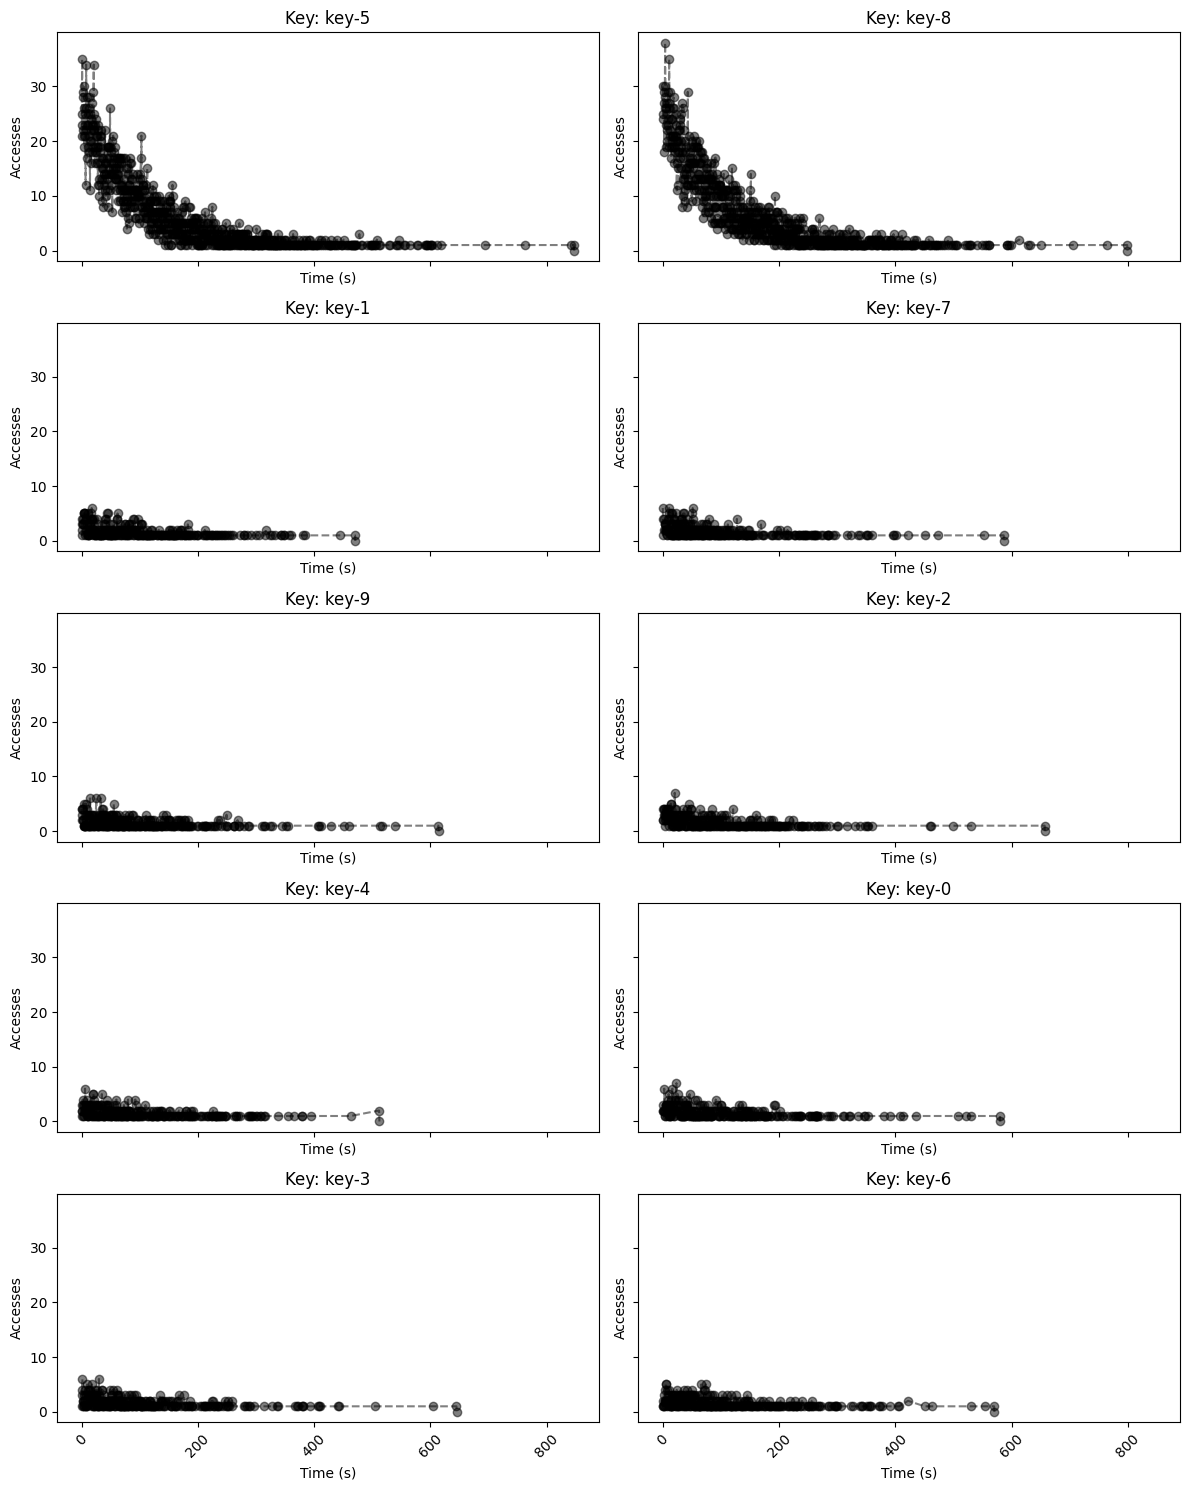

In [87]:
def generate_inhomogeneous_poisson(lambda0, beta, T_max):
    """
    Generate event timestamps for an inhomogeneous Poisson process using thinning.
    
    The intensity function is defined as:
        lambda(t) = lambda0 * exp(-beta * t)
    
    Parameters:
      lambda0 (float): Initial rate at time 0.
      beta (float): Decay parameter.
      T_max (float): Maximum simulation time.
      
    Returns:
      events (list): List of event timestamps.
    """
    events = []
    t = 0
    lambda_max = lambda0  # Maximum intensity at time t=0
    while t < T_max:
        # Generate candidate interarrival time from an exponential with rate lambda_max
        u = np.random.uniform()
        t_candidate = t - np.log(u) / lambda_max
        t = t_candidate
        if t >= T_max:
            break
        # Accept the event with probability lambda(t)/lambda_max = exp(-beta * t)
        if np.random.uniform() < np.exp(-beta * t):
            events.append(t)
    return events

def generate_decay_trace_v2(n_objects=100, pop_frac=0.2,
                         T_max=300, 
                         lambda0_pop=5, beta_pop=0.03,
                         lambda0_nonpop=1, beta_nonpop=0.01,
                         bucket_id="bucket-0"):
    """
    Generate a consumer trace simulating object accesses over time with exponentially decaying frequency.
    
    Each object (key) is accessed following an inhomogeneous Poisson process with intensity
    lambda(t) = lambda0 * exp(-beta*t). Popular objects (pop_frac of total) use higher lambda0
    and beta values to simulate a high initial access frequency that decays rapidly, whereas 
    non-popular objects use lower lambda0 and beta to simulate sparse accesses.
    
    Parameters:
      n_objects (int): Total number of unique objects (keys).
      pop_frac (float): Fraction of objects that are 'popular' (e.g., 0.2 means 20% are popular).
      T_max (float): Maximum time (in seconds) to simulate.
      lambda0_pop (float): Initial rate for popular objects.
      beta_pop (float): Decay rate for popular objects.
      lambda0_nonpop (float): Initial rate for non-popular objects.
      beta_nonpop (float): Decay rate for non-popular objects.
      bucket_id (str): Bucket identifier.
      
    Returns:
      pd.DataFrame: Trace with columns [timestamp, interarrival_time, bucket_id, key], sorted by timestamp.
    """
    all_events = []
    pop_count = int(n_objects * pop_frac)
    popular_indices = set(random.sample(range(n_objects), pop_count))
    
    for obj_id in range(n_objects):
        is_popular = (obj_id in popular_indices)
        if is_popular:
            lambda0 = lambda0_pop
            beta = beta_pop
        else:
            lambda0 = lambda0_nonpop
            beta = beta_nonpop
        
        # Generate event times for this object using the inhomogeneous Poisson process
        events = generate_inhomogeneous_poisson(lambda0, beta, T_max)
        # Calculate interarrival times from generated timestamps
        if events:
            events = np.array(events)
            interarrivals = np.diff(np.insert(events, 0, 0))
        else:
            events = []
            interarrivals = []
        
        key_str = f"key-{obj_id}"
        
        for t, it in zip(events, interarrivals):
            all_events.append({
                "timestamp": t,
                "interarrival_time": it,
                "bucket_id": bucket_id,
                "key": key_str
            })
    
    df = pd.DataFrame(all_events)
    df.sort_values("timestamp", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def plot_key_decay_v2(trace_df, key, interval=10):
    """
    Plot the decay of access frequency over time for a specific key.
    
    This function groups the events for the given key into fixed time intervals and plots
    the number of accesses in each interval to illustrate the decay.
    
    Parameters:
      trace_df (DataFrame): Trace with columns [timestamp, interarrival_time, bucket_id, key].
      key (str): The key to plot.
      interval (int): Time bin size in seconds.
    """
    df_key = trace_df[trace_df["key"] == key].copy()
    if df_key.empty:
        print(f"No events for {key}")
        return
    df_key["time_bin"] = (df_key["timestamp"] // interval) * interval
    access_counts = df_key.groupby("time_bin").size().reset_index(name="access_count")
    access_counts.sort_values("time_bin", inplace=True)
    
    plt.figure(figsize=(8, 5))
    plt.plot(access_counts["time_bin"], access_counts["access_count"], marker="o", linestyle="-", color="black")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Number of Accesses")
    plt.title(f"Access Decay for {key}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
n_objects = 10  # Total unique objects
trace2 = generate_decay_trace_v2(n_objects, 
    pop_frac=0.2, 
    T_max=3600, 
    lambda0_pop=50,
    beta_pop=.01,

    lambda0_nonpop=5,
    beta_nonpop=.0109,
    
    bucket_id="bucket-0"
)

unique_keys = trace2["key"].unique()
keys_to_plot = unique_keys[:10]  # Or use a random sample: np.random.choice(unique_keys, 10, replace=False)
plot_decay_for_keys_grid(trace2, keys_to_plot, interval=.5,save=True, marker="o", linestyle="--", color="black",alpha=.5)
# consumer_trace.to_csv("dynamic_consumer_trace.csv", index=False)
# print(consumer_trace.head())

# Plot the decay for a specific key (e.g., "key-5")
# plot_key_decay(consumer_trace, key="key-5", interval=10)

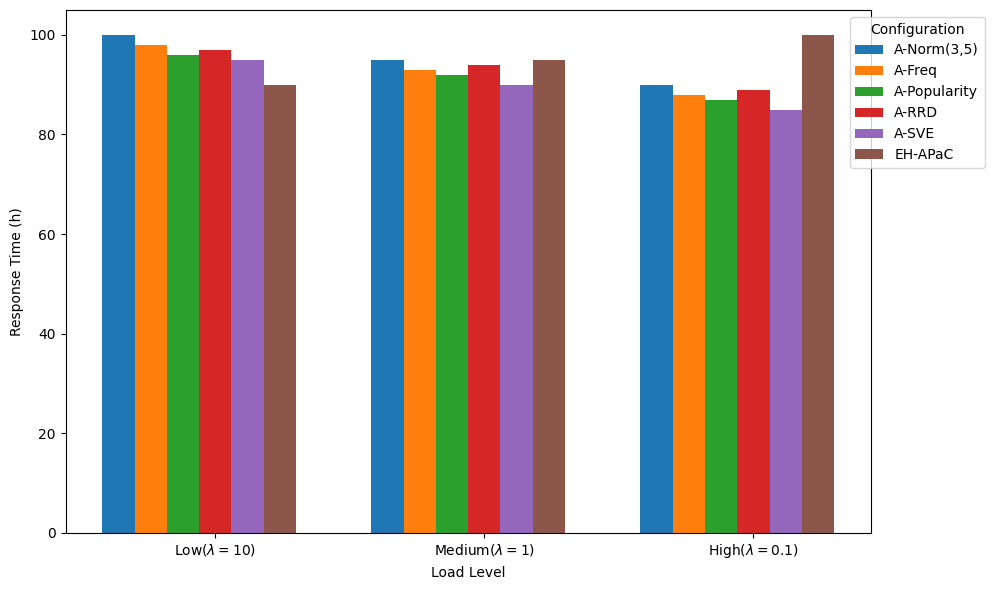

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Configuration names and load levels
configs = ["A-Norm(3,5)", "A-Freq", "A-Popularity", "A-RRD", "A-SVE", "EH-APaC"]
loads = ["Low($\lambda=10$)", "Medium($\lambda=1$)", "High($\lambda=0.1$)"]

# Performance values for each configuration at different load levels
performance = np.array([
    [100, 98, 96, 97, 95, 90],  # Low load: APaC is lower
    [95, 93, 92, 94, 90, 95],   # Medium load: APaC catches up
    [90, 88, 87, 89, 85, 100]   # High load: APaC outperforms others by ~11.5%
])

n_loads = performance.shape[0]
n_configs = performance.shape[1]

# Create an array for the positions of load groups on the x-axis
x = np.arange(n_loads)
width = 0.12  # Width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each configuration's performance as a set of bars within each load group
for i in range(n_configs):
    ax.bar(x + i * width - (n_configs / 2) * width, performance[:, i], width, label=configs[i])

# Set labels and title
ax.set_xlabel("Load Level")
ax.set_ylabel("Response Time (h)")
# ax.set_title("Performance Comparison of Replication Strategies Under Different Loads")
ax.set_xticks(x)
ax.set_xticklabels(loads)
ax.legend(title="Configuration", loc="upper right", bbox_to_anchor=(1.15, 1))
plt.tight_layout()

plt.show()